In [2]:
import numpy as np
# Importing standard Qiskit libraries
from qiskit import *
from qiskit import QuantumCircuit, transpile, execute, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from scipy.linalg import expm
import math
import matplotlib.pyplot as plt

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

ibmqfactory.load_account:WARNING:2021-06-25 08:25:03,305: Credentials are already in use. The existing account in the session will be replaced.


# QPE 2 Qubits

In [58]:
#Matriz de covarianza normalizada con la traza
p = np.array([[0.6407, 0.3288],[0.3288, 0.3593]])
print(p)

#Matriz unitaria e^2*pi*i*p
u=expm(2*np.pi*1j*p)
print(u)

[[0.6407 0.3288]
 [0.3288 0.3593]]
[[6.25925905e-01-0.30681596j 1.63586105e-16-0.71699423j]
 [2.11600786e-16-0.71699423j 6.25925905e-01+0.30681596j]]


In [111]:
#Inicializar vector de estado (superposicion)
stateVec = [1/np.sqrt(2), 1/np.sqrt(2)]
resultDict={}
legend=[]
#Repetir proceso para mayor precision
for i in range(0, 5):
    #Crear circuito con 3 qubits, 2 parte superior y 1 inferior
    circuit = QuantumCircuit(3,3)
    #Inicializacion qubit 2 en con el vector de estado
    circuit.initialize(stateVec, 2)
    #Aplicar puertas de hadamard a qubits 0 y 1, para aplicar Quantum Amplitude Estimation sobre la matriz unitaria
    circuit.h([0,1])
    #Calcular rotaciones de la puerta de la matriz unitaria (controller u gate)
    (theta, phi, lamb) = qiskit.quantum_info.OneQubitEulerDecomposer(basis='U3').angles(expm(2*1j*np.pi*p))
    #Aplicar rotaciones
    circuit.cu(theta,phi,lamb, 0, 1, 2)
    #Calcular rotaciones de la puerta de la matriz unitaria (u**2)
    (theta2, phi2, lamb2) = qiskit.quantum_info.OneQubitEulerDecomposer(basis='U3').angles(expm(2*1j*np.pi*p*2))
    #Aplicar rotaciones
    circuit.cu(theta2,phi2,lamb2, 0, 0, 2)
    
    #Aplicar Inverse Quantum Fourier Transform en los qubits 0 y 1
    circuit.h(0)
    circuit.crz(-np.pi/2,0,1)
    circuit.h(1)
    #print(Statevector(circuit))
    #Medir los qubits
    circuit.measure([0,1,2], [0,1,2])
    #Ejecutar circuito en el simulador y guardar resultados obtenidos
    results = execute(circuit, backend=BasicAer.get_backend('qasm_simulator'), shots=4096).result().get_counts()
    #Guardar resultados en diccionario correspondiente
    resultDict['Results'+str(i)]=results
    legend.append(str(i+1)+". execución")
    #resultMatrix[i,:]=results
    #Conteo de los estados relacionados con la proyeccion 11 (011 y 111)
    denominator = results['111'] + results['011']
    #Calcular coeficientes del eigenvector
    alpha1 = np.sqrt(results['011'] / denominator)
    alpha2 = np.sqrt(results['111'] / denominator)
    
    #Guardar nuevo estado inicial del qubit 2 para la siguiente ejecucion
    stateVec = [alpha1, alpha2]

print("Eigenvector obtenido: ",stateVec)

Eigenvector obtenido:  [0.8336157713463008, 0.552344770738994]


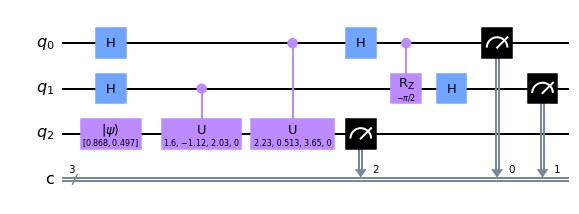

In [21]:
circuit.draw(output='mpl')

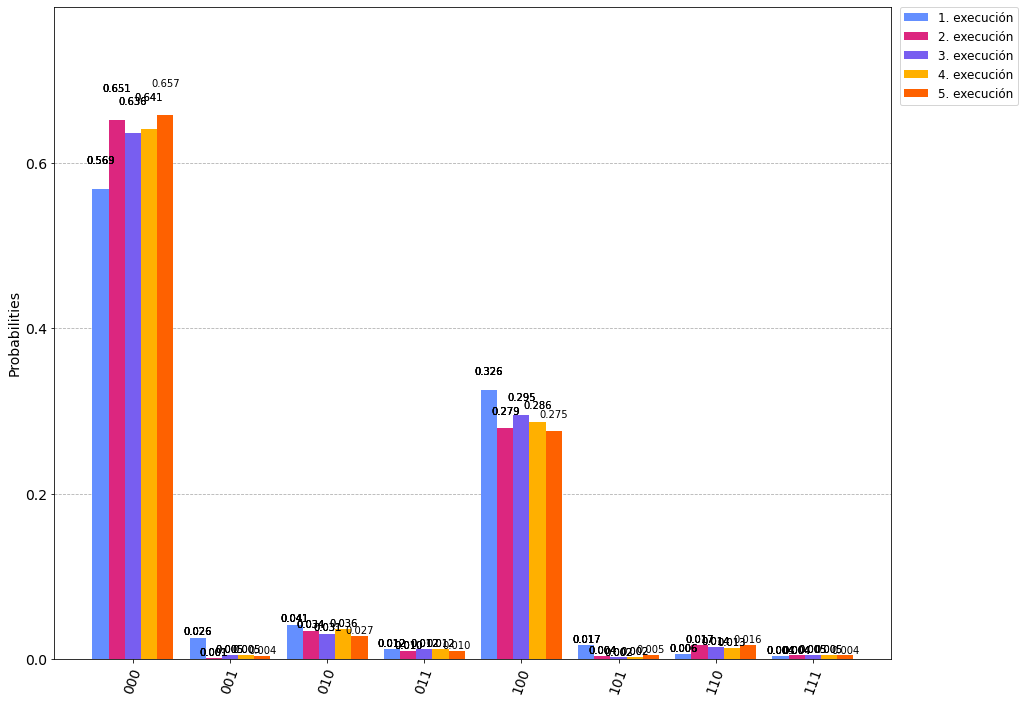

<Figure size 432x288 with 0 Axes>

In [129]:
#plot_histogram(results)
plot_histogram(resultDict.values(), legend=legend, figsize=(15,12), color=plt.inferno())#, bar_labels=False)

# Constructor QPE Generalizado

In [171]:
#Creacion del circuito QPE con n qubits superiores y m inferiores, la matriz de covarianza normalizada p y el vector estado
def QPE(n,m,p, stateVector):
    #Circuito con n+m qubits y bits clasicos
    #qpeCircuit=QuantumCircuit(n+m,n+m)
    qpeCircuit=QuantumCircuit(n+m)
    #Indices de los n qubits superiores
    nNumbers=np.arange(0,n).tolist()
    #Aplicar puertas de hadamard a los qubits superiores
    qpeCircuit.h(nNumbers)
    
    #Indices de los m qubits inferiores
    mNumbers=np.arange(n,n+m).tolist()
    #Iniciar m qubits inferiores con el vector de estado
    for i in range(n,n+m):
        #qpeCircuit.initialize(stateVector,i)
        qpeCircuit.ry(1,i)
        qpeCircuit.rz(0.33,i)
    
    #Aplicar las puertas controladas de U entre los qubits superiores e inferiores
    for i in range(0,n):
        #Calcular rotacion de la matriz de covarianza para la puerta controlada U
        (theta, phi, lamb) = qiskit.quantum_info.OneQubitEulerDecomposer(basis='U3').angles(expm(2*1j*np.pi*p*(2**i)))
        #Aplicar rotaciones theta, phi, lambda, gamma=0
        qpeCircuit.cu(theta,phi,lamb, 0, n-1-i, mNumbers)
    
    #Llamar a la funcion de creacion de IQFT para los n qubits superiores
    iqftC=IQFT(n) 
    #Combinar los dos circuitos
    xd=QuantumCircuit.compose(qpeCircuit,iqftC)
    #Realizar las mediciones
    #xd.measure(nNumbers+mNumbers,nNumbers+mNumbers)
    xd.measure_all()
    return xd


#Creacion del circuito Inverse Quantum Fourier Transform con n qubits  
def IQFT(n):
    #Definir circuito de n qubits y n bits clasicos
    #iqftCircuit=QuantumCircuit(n,n)
    iqftCircuit=QuantumCircuit(n)
    
    #Aplicar las rotaciones respectivas a cada qubit, desde el 0 hasta el n-1
    for i in range(0,n):
        for j in range(0,i):
            iqftCircuit.crz(-np.pi/(2**(j+1)), (i-1-j),i)
        
        #Aplicar puerta de hadamard despues de aplicar las rotaciones en cada qubit
        iqftCircuit.h(i)    
    return iqftCircuit

#Creacion del circuito Inverse Quantum Fourier Transform con n qubits, Metodo 2 (paper Finances)
def IQFT2(n):
    iqftCircuit=QuantumCircuit(n)
    #Aplicar las rotaciones respectivas a cada qubit, desde el 0 hasta el n-1
    for i in range(0,n):
        #Aplicar puerta de hadamard antes de aplicar las rotaciones en cada qubit
        iqftCircuit.h(i)
        for j in range(i,n-1):
            iqftCircuit.crz(-np.pi/(2**(j+1)), i,j+1)
    return iqftCircuit

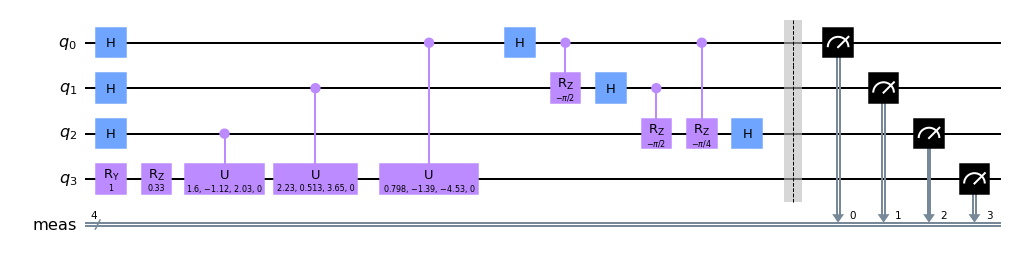

In [172]:
#n=3, m=1, matriz=p, vector estado= |+>
xd2=QPE(3,1,p, np.array([1/np.sqrt(2), 1/np.sqrt(2)]))  
xd2.draw(output='mpl')

## Ejecucion de QPE con 3 qubits (2+1)

Eigenvector obtenido:  [0.7931155389125321, 0.6090712125322324]


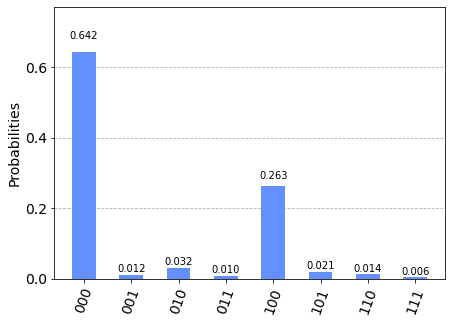

In [181]:
#Inicializar vector de estado |+>
stateVec = [1/np.sqrt(2), 1/np.sqrt(2)]
for i in range(0,10):
    circuit=QPE(2,1,p,stateVec)
    results = execute(circuit, backend=BasicAer.get_backend('qasm_simulator'), shots=4096).result().get_counts()
    #Conteo de los estados relacionados con la proyeccion 11 (011 y 111)
    denominator = results['111'] + results['011']
    #Calcular coeficientes del eigenvector
    alpha1 = np.sqrt(results['011'] / denominator)
    alpha2 = np.sqrt(results['111'] / denominator)
    
    #Guardar nuevo estado inicial del qubit 2 para la siguiente ejecucion
    stateVec = [alpha1, alpha2]

print("Eigenvector obtenido: ",stateVec)
plot_histogram(results)

## Ejecucion de QPE con 4 qubits (3+1)

Eigenvector obtenido:  [0.7878385971583354, 0.6158817620514397]


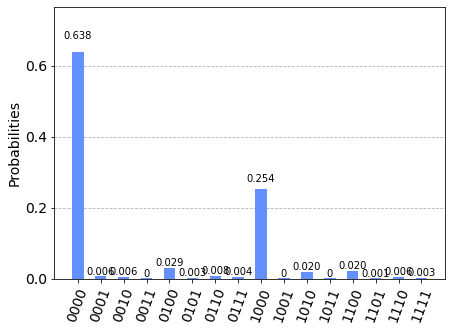

In [190]:
#Inicializar vector de estado |+>
stateVec = [1/np.sqrt(2), 1/np.sqrt(2)]
for i in range(0,10):
    circuit=QPE(3,1,p,stateVec)
    results = execute(circuit, backend=BasicAer.get_backend('qasm_simulator'), shots=4096).result().get_counts()
    #Conteo de los estados relacionados con la proyeccion 11 (011 y 111)
    denominator = results['0111'] + results['1111']
    #Calcular coeficientes del eigenvector
    alpha1 = np.sqrt(results['0111'] / denominator)
    alpha2 = np.sqrt(results['1111'] / denominator)
    
    #Guardar nuevo estado inicial del qubit 2 para la siguiente ejecucion
    stateVec = [alpha1, alpha2]

print("Eigenvector obtenido: ",stateVec)
plot_histogram(results)

# Circuito 4 qubits

In [6]:
#Matriz de covarianza normalizada con la traza
p = np.array([[0.4489, 0.2304,0.2162,0],[0.2304, 0.2518,0.2399,0],[0.2162,0.2399,0.2993,0],[0,0,0,0]])
print(p)

#Matriz unitaria e^2*pi*i*p
u=expm(2*np.pi*1j*p)
#Redondear a tres decimales al printear
print(u.round(3))

[[0.4489 0.2304 0.2162 0.    ]
 [0.2304 0.2518 0.2399 0.    ]
 [0.2162 0.2399 0.2993 0.    ]
 [0.     0.     0.     0.    ]]
[[ 0.415+0.048j -0.108-0.565j -0.029-0.702j  0.   +0.j   ]
 [-0.108-0.565j  0.744-0.03j  -0.285-0.181j  0.   +0.j   ]
 [-0.029-0.702j -0.285-0.181j  0.618+0.099j  0.   +0.j   ]
 [ 0.   +0.j     0.   +0.j     0.   +0.j     1.   +0.j   ]]


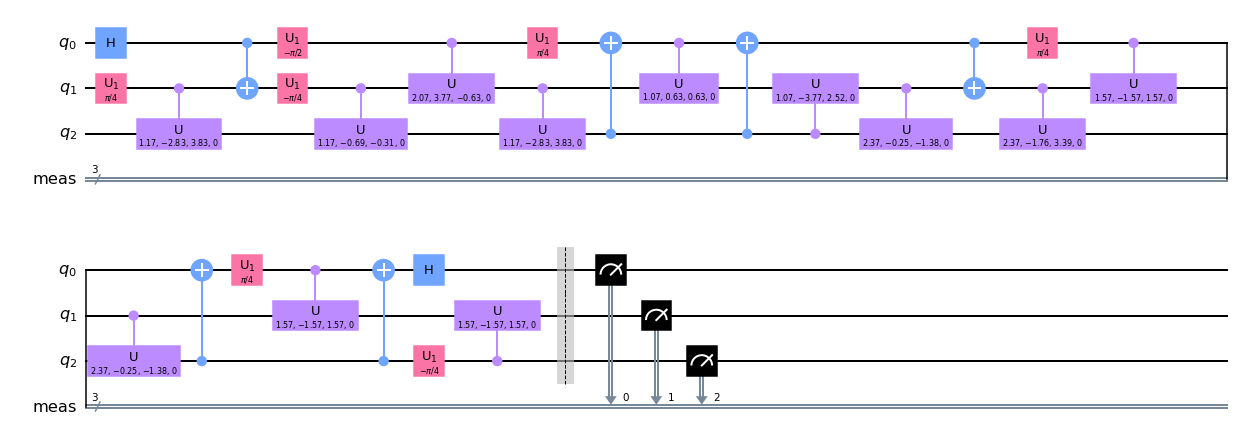

In [84]:
from qiskit.quantum_info import Statevector
#Crear circuito con 3 qubits, 2 parte superior y 1 inferior
circuit = QuantumCircuit(3)

#Aplicar puerta de hadamard a qubit 0
circuit.h(0)

circuit.u1(np.pi/4,1)
#Calcular rotaciones de la puerta de la matriz unitaria (controller u gate)
#(theta, phi, lamb) = qiskit.quantum_info.OneQubitEulerDecomposer(basis='U3').angles(expm(2*1j*np.pi*p*2))
#Aplicar rotaciones
circuit.cu(1.17,-2.83,3.83, 0, 1, 2)
#Controlled not 
circuit.cx(0,1)
#Puertas U
circuit.u1(-np.pi/2,0)
circuit.u1(-np.pi/4,1)


#(theta, phi, lamb) = qiskit.quantum_info.OneQubitEulerDecomposer(basis='U').angles(expm(2*1j*np.pi*p))
circuit.cu(1.17,-0.69,-0.31, 0, 1, 2)

#(theta, phi, lamb) = qiskit.quantum_info.OneQubitEulerDecomposer(basis='U').angles(expm(2*1j*np.pi*p))
circuit.cu(2.07,3.77,-0.63, 0, 0, 1)

circuit.u1(np.pi/4,0)

#(theta, phi, lamb) = qiskit.quantum_info.OneQubitEulerDecomposer(basis='U').angles(expm(2*1j*np.pi*p))
circuit.cu(1.17,-2.83,3.83, 0, 1, 2)

circuit.cx(2,0)


#(theta, phi, lamb) = qiskit.quantum_info.OneQubitEulerDecomposer(basis='U').angles(expm(2*1j*np.pi*p))
circuit.cu(1.07,0.63, 0.63, 0, 0, 1)
circuit.cx(2,0)
#(theta, phi, lamb) = qiskit.quantum_info.OneQubitEulerDecomposer(basis='U').angles(expm(2*1j*np.pi*p))
circuit.cu(1.07,-3.77,2.52, 0, 2, 1)

#Parte 2 del circuito
#(theta, phi, lamb) = qiskit.quantum_info.OneQubitEulerDecomposer(basis='U').angles(expm(2*1j*np.pi*p))
circuit.cu(2.37,-0.25,-1.38, 0, 1, 2)
circuit.cx(0,1)
circuit.u1(np.pi/4,0)

#(theta, phi, lamb) = qiskit.quantum_info.OneQubitEulerDecomposer(basis='U').angles(expm(2*1j*np.pi*p))
circuit.cu(2.37,-1.76,3.39, 0, 1, 2)
#(theta, phi, lamb) = qiskit.quantum_info.OneQubitEulerDecomposer(basis='U').angles(expm(2*1j*np.pi*p))
circuit.cu(1.57,-1.57,1.57, 0, 0, 1)
#(theta, phi, lamb) = qiskit.quantum_info.OneQubitEulerDecomposer(basis='U').angles(expm(2*1j*np.pi*p))
circuit.cu(2.37,-0.25,-1.38, 0, 1, 2)

circuit.cx(2,0)
circuit.u1(np.pi/4,0)
#(theta, phi, lamb) = qiskit.quantum_info.OneQubitEulerDecomposer(basis='U').angles(expm(2*1j*np.pi*p))
circuit.cu(1.57,-1.57,1.57, 0, 0, 1)
circuit.cx(2,0)
circuit.h(0)
circuit.u1(-np.pi/4,2)
#(theta, phi, lamb) = qiskit.quantum_info.OneQubitEulerDecomposer(basis='U').angles(expm(2*1j*np.pi*p))
circuit.cu(1.57,-1.57,1.57, 0, 2, 1)
#Metodo 1 para obtener estado vector final, antes de las mediciones
#stateVectorFinal=Statevector(circuit)
#Metodo 2: Ejecutar el simulador de vector de estado antes de realizar mediciones
sv = execute(circuit, backend=BasicAer.get_backend('statevector_simulator'), shots=4096).result().get_statevector()
circuit.measure_all()
circuit.draw(output='mpl')

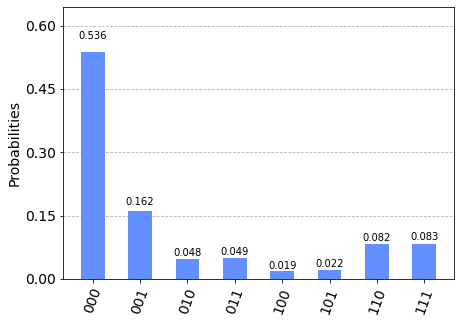

In [85]:
results = execute(circuit, backend=BasicAer.get_backend('qasm_simulator'), shots=4096).result().get_counts()
plot_histogram(results)

In [131]:
#plot_bloch_multivector(sv)

In [130]:
#plot_state_qsphere(sv)

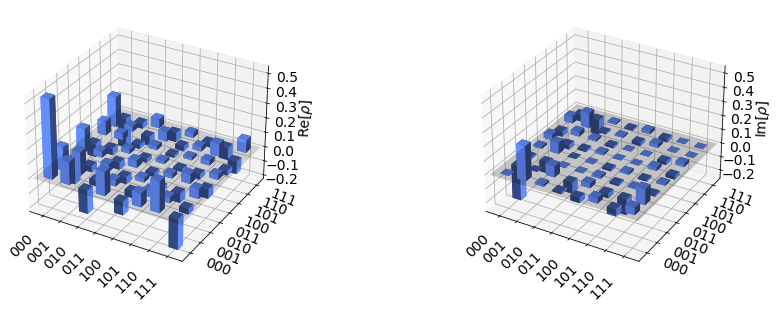

In [87]:
from qiskit.visualization import plot_state_city
plot_state_city(sv)

In [89]:
print("Estado final antes de la medición: \n", sv)
#Los dos metodos validos para printear el estado final
#print(stateVectorFinal)

Estado final antes de la medición: 
 [ 0.68775992+0.24605734j  0.31224008-0.24605734j -0.20111051-0.09160958j
  0.20111051+0.09160958j -0.13763373+0.00525977j  0.13763373-0.00525977j
  0.24638793+0.16027017j -0.24638793-0.16027017j]


In [40]:
denominator = results['100'] + results['101'] + results['110'] + results['111']
#Calcular coeficientes del eigenvector
alpha1 = np.sqrt(results['100'] / denominator)
alpha2 = np.sqrt(results['101'] / denominator)
alpha3 = np.sqrt(results['110'] / denominator)
alpha4 = np.sqrt(results['111'] / denominator)
#Guardar nuevo estado inicial del qubit 2 para la siguiente ejecucion
stateVec = [alpha1, alpha2,alpha3,alpha4]

print("Eigenvector obtenido: ",stateVec)

Eigenvector obtenido:  [0.2943655106566811, 0.3079736598731197, 0.6291140940445754, 0.6501666152876971]
